In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import dates as mpl_dates
import seaborn as sns 
import matplotlib.dates as mdates
import datetime
import plotly.express as px
import plotly.graph_objects as go
import os
import arcgis
from arcgis.gis import GIS
from mpl_toolkits.basemap import Basemap, addcyclic




c:\Users\Morgan\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Took the covid CSV and read it in as dataframe
covid_df = pd.read_csv('../data/owid-covid-data.csv')
covid_df ['date'] = pd.to_datetime(
    covid_df ['date']
)
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204992 entries, 0 to 204991
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    204992 non-null  object        
 1   continent                                   204037 non-null  object        
 2   location                                    204992 non-null  object        
 3   date                                        204992 non-null  datetime64[ns]
 4   total_cases                                 196122 non-null  float64       
 5   new_cases                                   195790 non-null  float64       
 6   new_cases_smoothed                          194663 non-null  float64       
 7   total_deaths                                177260 non-null  float64       
 8   new_deaths                                  176993 non-null  float64      

In [3]:
#Took the protest CSV and read it in as dataframe
acled_df = pd.read_csv('../data/acled_midterm.csv')
#Converting "event_date" to date type instead of str/object
acled_df['event_date'] = pd.to_datetime(
    acled_df['event_date']
)
acled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803024 entries, 0 to 803023
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   data_id           803024 non-null  int64         
 1   iso               803024 non-null  int64         
 2   event_id_cnty     803024 non-null  object        
 3   event_id_no_cnty  803024 non-null  int64         
 4   event_date        803024 non-null  datetime64[ns]
 5   year              803024 non-null  int64         
 6   time_precision    803024 non-null  int64         
 7   event_type        803024 non-null  object        
 8   sub_event_type    803024 non-null  object        
 9   actor1            803024 non-null  object        
 10  assoc_actor_1     359190 non-null  object        
 11  inter1            803024 non-null  int64         
 12  actor2            334361 non-null  object        
 13  assoc_actor_2     95961 non-null   object        
 14  inte

In [4]:
#Objectives with the data
    # Over the past three years has civilian protests increased or decreased per country?
         # Does the quantity of protests correlate with the increase or decrease of social media usage? If so what social media platforms is this country primarily using?
    # Is there a correlation between violence agaianst protestsors and the quantity of protests per country?

In [5]:
#Take original "timestamp" column and extract month making a new column in order to map protests by month over a 3 year span
acled_df['month'] = pd.DatetimeIndex(acled_df['event_date']).month_name().str[:3]
acled_df = acled_df.set_index('month')
acled_df.head(5)

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
month,,,,,,,,,,,,,,,,,,,,,
Sep,9458560,188,CRI1681,1681,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Costa Rica),...,San Jose,9.9356,-84.0986,1,Diario Extra; Teletica; La Teja; Amprensa,National,"On 1 September 2022, in San Jose, Hospital, Sa...",0,1663001494,CRI
Sep,9458592,320,GTM5386,5386,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Guatemala),...,San Vicente Pacaya,14.4144,-90.6359,2,El Periodico; Prensa Libre (Guatemala),National,"On 1 September 2022, near San Vicente Pacaya, ...",0,1663001494,GTM
Sep,9458803,484,MEX64680,64680,2022-09-01,2022,2,Violence against civilians,Attack,Unidentified Gang (Mexico),...,Tijuana,32.5325,-117.0190,1,AFN - Tijuana; Riodoce,Subnational-National,"Around 1 September 2022 (as reported), in Tiju...",1,1663001495,MEX
Sep,9458804,484,MEX64695,64695,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,Tepeji del Rio de Ocampo,19.9048,-99.3437,2,Diario Via Libre; El Sol de Hidalgo; Milenio,Subnational-National,"On 1 September 2022, in Tepeji del Rio de Ocam...",0,1663001495,MEX
Sep,9458805,484,MEX64698,64698,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,Soyaniquilpan de Juarez,20.0149,-99.5302,2,Diario Via Libre; Milenio,National,"On 1 September 2022, between Soyaniquilpan de ...",0,1663001495,MEX


In [6]:
#separate protests in the event_type column
acled_event_protests = acled_df.loc[acled_df['event_type'] == 'Protests']
acled_event_protests['data_id'].count()


423413

In [7]:
#acled_event_protests_subevents = acled_event_protests[['actor1', 'sub_event_type', 'event_date']]

In [8]:
#acled_event_protests_subevents.value_counts('actor1')

In [9]:
# Creating new column that will count how many times a specififc actor is involed in a protest. Did this so I coud determine the top ten countries with the most protests.
#Realized I didnt need to do this it was already done with code below if i would have ended it with .head(10). But leaving it in case it comes in handy.
acled_event_protests['Count'] = acled_event_protests['actor1'].map(acled_event_protests['actor1'].value_counts())
acled_event_protests

C:\Users\Morgan\AppData\Local\Temp\ipykernel_25008\3051431486.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acled_event_protests['Count'] = acled_event_protests['actor1'].map(acled_event_protests['actor1'].value_counts())


,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3,Count
month,,,,,,,,,,,,,,,,,,,,,
Sep,9458560,188,CRI1681,1681,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Costa Rica),...,9.9356,-84.0986,1,Diario Extra; Teletica; La Teja; Amprensa,National,"On 1 September 2022, in San Jose, Hospital, Sa...",0,1663001494,CRI,885
Sep,9458592,320,GTM5386,5386,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Guatemala),...,14.4144,-90.6359,2,El Periodico; Prensa Libre (Guatemala),National,"On 1 September 2022, near San Vicente Pacaya, ...",0,1663001494,GTM,1057
Sep,9458804,484,MEX64695,64695,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,19.9048,-99.3437,2,Diario Via Libre; El Sol de Hidalgo; Milenio,Subnational-National,"On 1 September 2022, in Tepeji del Rio de Ocam...",0,1663001495,MEX,17740
Sep,9458805,484,MEX64698,64698,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,20.0149,-99.5302,2,Diario Via Libre; Milenio,National,"On 1 September 2022, between Soyaniquilpan de ...",0,1663001495,MEX,17740
Sep,9458806,484,MEX64701,64701,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,18.9218,-99.2349,1,Diario de Morelos; La Jornada,National,"On 1 September 2022, in Cuernavaca, Morelos, r...",0,1663001495,MEX,17740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sep,9323847,729,SUD13140,13140,2019-09-01,2019,1,Protests,Peaceful protest,Protesters (Sudan),...,13.5538,23.8471,1,Radio Dabanga,National,"On 1 September 2019, supporters of RAC leader ...",0,1653503189,SDN,2808
Sep,9333432,792,TUR9140,9140,2019-09-01,2019,1,Protests,Protest with intervention,Protesters (Turkey),...,39.9117,32.8403,1,Human Rights Foundation of Turkey,Other,"On 1 September 2019, the former public workers...",0,1653503224,TUR,9328
Sep,9433291,360,IDN5612,5612,2019-09-01,2019,1,Protests,Peaceful protest,Protesters (Indonesia),...,-6.1806,106.8283,1,Kompas,National,"On 1 September 2019, a group of women from the...",0,1659475468,IDN,4858


In [10]:
#Added two data frames together.
df_all_cols = pd.concat([acled_event_protests, covid_df])
df_all_cols.head(5)

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
Sep,9458560.0,188.0,CRI1681,1681.0,2022-09-01,2022.0,1.0,Protests,Peaceful protest,Protesters (Costa Rica),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sep,9458592.0,320.0,GTM5386,5386.0,2022-09-01,2022.0,1.0,Protests,Peaceful protest,Protesters (Guatemala),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sep,9458804.0,484.0,MEX64695,64695.0,2022-09-01,2022.0,1.0,Protests,Peaceful protest,Protesters (Mexico),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sep,9458805.0,484.0,MEX64698,64698.0,2022-09-01,2022.0,1.0,Protests,Peaceful protest,Protesters (Mexico),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sep,9458806.0,484.0,MEX64701,64701.0,2022-09-01,2022.0,1.0,Protests,Peaceful protest,Protesters (Mexico),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#Verified the count above is correct by confirming India as 44573. Will now use count to identify top twenty countries with the most protests.
acled_df_sort_bar_toptwenty = acled_event_protests.value_counts('actor1').head(20)
acled_df_sort_bar_toptwenty

actor1
Protesters (India)             44573
Protesters (United States)     43267
Protesters (Pakistan)          21058
Protesters (Mexico)            17740
Protesters (France)            17346
Protesters (South Korea)       16764
Protesters (Italy)             15879
Protesters (Germany)           11970
Protesters (Spain)             10689
Protesters (Turkey)             9328
Protesters (Iran)               8922
Protesters (Brazil)             8905
Protesters (Myanmar)            7958
Protesters (Nepal)              7853
Protesters (Argentina)          7605
Protesters (Lebanon)            7204
Protesters (Venezuela)          6778
Protesters (Russia)             5024
Protesters (Indonesia)          4858
Protesters (United Kingdom)     4772
dtype: int64

c:\Users\Morgan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


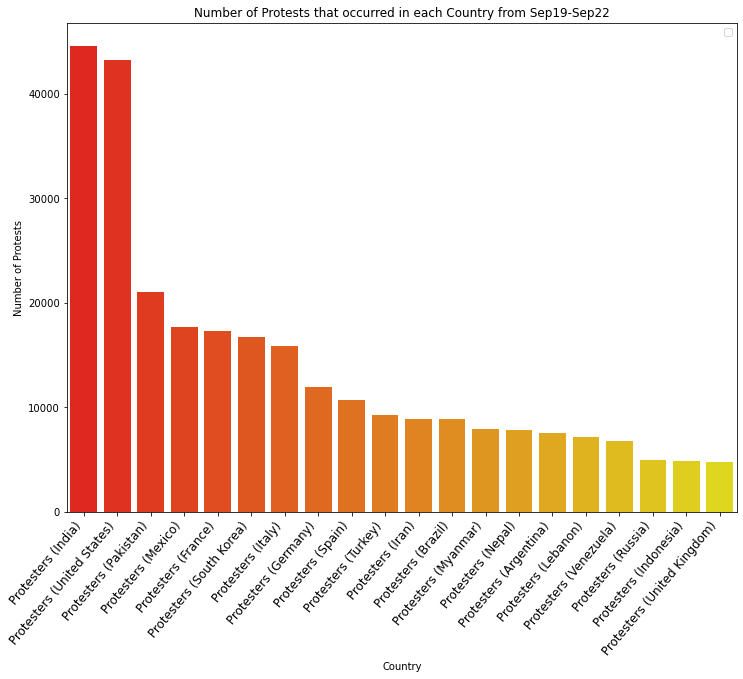

In [45]:
#Graphed (bar) top twenty countries with the most protests
fig, ax = plt.subplots(figsize=(12,9))
sns.barplot(acled_df_sort_bar_toptwenty.index, acled_df_sort_bar_toptwenty, palette='autumn')
ax.set_xticklabels(acled_df_sort_bar_toptwenty.index, rotation=90, horizontalalignment = 'right', fontsize = '12')
plt.ticklabel_format(axis='y',style='plain')
#ax.set_xticklabels(cat_name, rotation=60, horizontalalignment='right', fontsize='12')
plt.xticks(rotation=50, horizontalalignment='right', fontsize='12')
plt.xlabel("Country")
plt.ylabel("Number of Protests")
plt.title("Number of Protests that occurred in each Country from Sep19-Sep22")
plt.legend()
plt.show()

In [13]:
#Created new variable of the twenty countries with the lowest amount of protests. But all twenty had only 1. I want to gleam a little more from the data.
# These actors could be smaller factions that ACLED still reports on.
acled_df_sort_bar_bottomtwenty = acled_event_protests.value_counts('actor1').tail(20)
acled_df_sort_bar_bottomtwenty

actor1
STC: Southern Transitional Council (Security Belt Forces)          1
Sadrist Movement                                                   1
Shiite Muslim Militia (Iraq)                                       1
Military Forces of Iraq (2018-2020) Popular Mobilization Forces    1
Police Forces of Iran (1989-)                                      1
Police Forces of Zimbabwe (2017-)                                  1
Police Forces of Israel (2009-2021)                                1
Police Forces of Morocco (1999-)                                   1
Police Forces of Somalia (2017-2022)                               1
Private Security Forces (Iraq)                                     1
Protesters (Bhutan)                                                1
Protesters (British Virgin Islands)                                1
Protesters (Christmas Islands)                                     1
Protesters (Congo)                                                 1
Protesters (Cook Islands)  

C:\Users\Morgan\AppData\Local\Temp\ipykernel_25008\928888995.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(acled_df_sort_bar_bottomtwenty.index, rotation=90, horizontalalignment = 'right', fontsize = '12')


<function matplotlib.pyplot.show(close=None, block=None)>

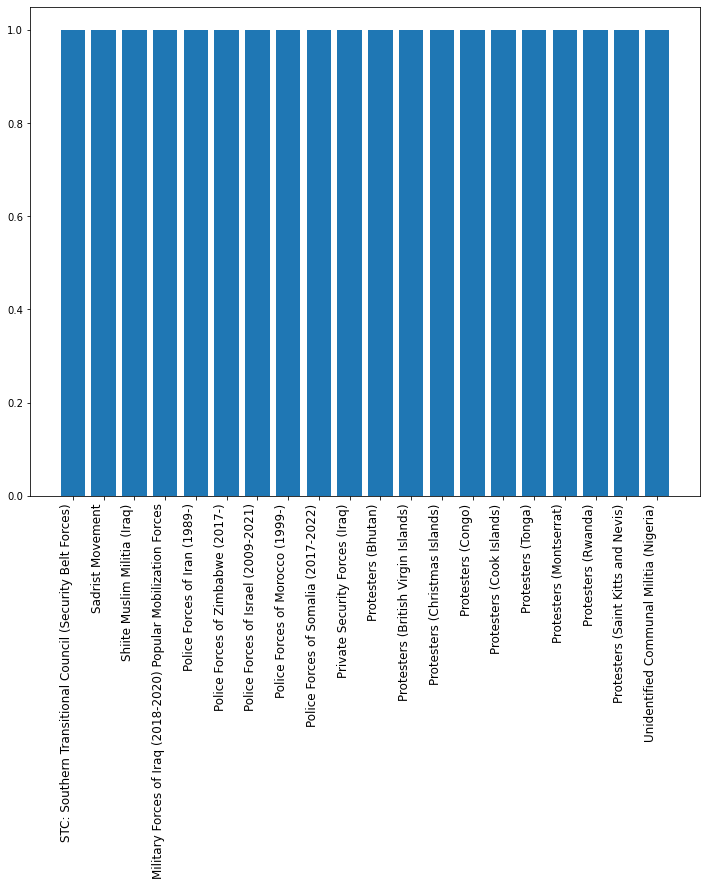

In [14]:
#Graphed the twenty countries with the lowest amount of protests
fig, ax = plt.subplots(figsize=(12,9))
ax.bar(acled_df_sort_bar_bottomtwenty.index, acled_df_sort_bar_bottomtwenty)
ax.set_xticklabels(acled_df_sort_bar_bottomtwenty.index, rotation=90, horizontalalignment = 'right', fontsize = '12')
plt.show

In [15]:
#Beacuse I didnt get as much insight from the actors with only 1 protest I made a variable that returned all actors with protests greater than one.
acled_df_sort_bar_bottomtwenty_greaterone = acled_event_protests[(acled_event_protests['Count'] > 1)]
acled_df_sort_bar_bottomtwenty_greaterone

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3,Count
month,,,,,,,,,,,,,,,,,,,,,
Sep,9458560,188,CRI1681,1681,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Costa Rica),...,9.9356,-84.0986,1,Diario Extra; Teletica; La Teja; Amprensa,National,"On 1 September 2022, in San Jose, Hospital, Sa...",0,1663001494,CRI,885
Sep,9458592,320,GTM5386,5386,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Guatemala),...,14.4144,-90.6359,2,El Periodico; Prensa Libre (Guatemala),National,"On 1 September 2022, near San Vicente Pacaya, ...",0,1663001494,GTM,1057
Sep,9458804,484,MEX64695,64695,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,19.9048,-99.3437,2,Diario Via Libre; El Sol de Hidalgo; Milenio,Subnational-National,"On 1 September 2022, in Tepeji del Rio de Ocam...",0,1663001495,MEX,17740
Sep,9458805,484,MEX64698,64698,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,20.0149,-99.5302,2,Diario Via Libre; Milenio,National,"On 1 September 2022, between Soyaniquilpan de ...",0,1663001495,MEX,17740
Sep,9458806,484,MEX64701,64701,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,18.9218,-99.2349,1,Diario de Morelos; La Jornada,National,"On 1 September 2022, in Cuernavaca, Morelos, r...",0,1663001495,MEX,17740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sep,9323847,729,SUD13140,13140,2019-09-01,2019,1,Protests,Peaceful protest,Protesters (Sudan),...,13.5538,23.8471,1,Radio Dabanga,National,"On 1 September 2019, supporters of RAC leader ...",0,1653503189,SDN,2808
Sep,9333432,792,TUR9140,9140,2019-09-01,2019,1,Protests,Protest with intervention,Protesters (Turkey),...,39.9117,32.8403,1,Human Rights Foundation of Turkey,Other,"On 1 September 2019, the former public workers...",0,1653503224,TUR,9328
Sep,9433291,360,IDN5612,5612,2019-09-01,2019,1,Protests,Peaceful protest,Protesters (Indonesia),...,-6.1806,106.8283,1,Kompas,National,"On 1 September 2019, a group of women from the...",0,1659475468,IDN,4858


In [16]:
#Listed the actors with greater than one protest
acled_df_sort_bar_bottomtwenty_greaterone_actor = acled_df_sort_bar_bottomtwenty_greaterone.value_counts('actor1').tail(20)
acled_df_sort_bar_bottomtwenty_greaterone_actor

actor1
Protesters (North Korea)                                     5
Protesters (United Arab Emirates)                            5
Protesters (Vanuatu)                                         4
Unidentified Armed Group (Lebanon)                           4
Protesters (Turks and Caicos)                                4
Protesters (Singapore)                                       4
Protesters (Saudi Arabia)                                    4
Protesters (American Samoa)                                  4
Protesters (US Virgin Islands)                               3
Protesters (Saint Vincent and the Grenadines)                3
Protesters (Anguilla)                                        3
HTS: Hayat Tahrir al Sham                                    3
Protesters (Saint Helena, Ascension and Tristan da Cunha)    2
Kataib Hezbollah (Iraq)                                      2
Protesters (Laos)                                            2
Protesters (Equatorial Guinea)                  

C:\Users\Morgan\AppData\Local\Temp\ipykernel_25008\785954230.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(acled_df_sort_bar_bottomtwenty_greaterone_actor.index, rotation=90, horizontalalignment = 'right', fontsize = '12')


<function matplotlib.pyplot.show(close=None, block=None)>

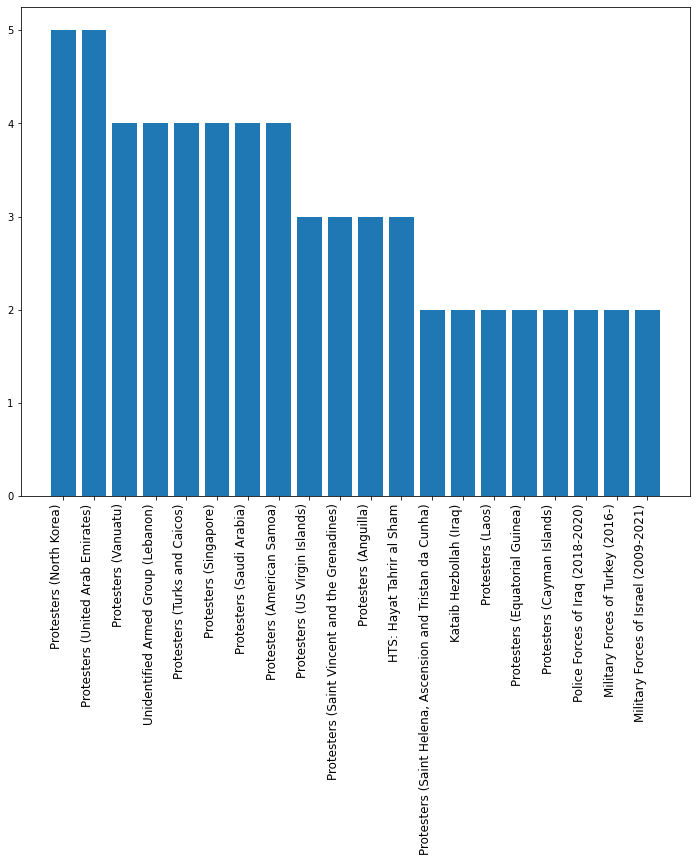

In [17]:
#graphed (bar) the actors with the lowest amount of protests but have more than one protest documented.
fig, ax = plt.subplots(figsize=(12,9))
ax.bar(acled_df_sort_bar_bottomtwenty_greaterone_actor.index, acled_df_sort_bar_bottomtwenty_greaterone_actor)
ax.set_xticklabels(acled_df_sort_bar_bottomtwenty_greaterone_actor.index, rotation=90, horizontalalignment = 'right', fontsize = '12')
plt.show

In [18]:
#Count of rows for evet type "protests" grouped by year as a test to confirm that filtering the datetime was working as its supposed to.
#acled_df.loc[acled_df['event_type'] == 'Protests'].groupby(by='year').count()
#acled_event_protests[(acled_event_protests['event_date'] > pd.Timestamp('01 September 2020'))].groupby(by='year').count()


In [19]:
#covid per year sep2019-sep2020
covid_cases_201909_202009 = df_all_cols[(df_all_cols['date'] > '01 September 2019') & (df_all_cols['date'] <= '31 August 2020')]
covid_cases_201909_202009

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204239,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
204240,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
204241,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
204242,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [20]:
# I mapped all three years worth of protests on a map. it ended up being to much data to coherently identify what the data was telling us. So now I will break it down by year and map the data by year.
# Filtering the data by year protests per sep2019-sep2020
acled_event_protests_201909_202009 = acled_event_protests[(acled_event_protests['event_date'] > '01 September 2019') & (acled_event_protests['event_date'] <= '31 August 2020')]
acled_event_protests_201909_202009


,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3,Count
month,,,,,,,,,,,,,,,,,,,,,
Aug,7177710,422,LBN5756,5756,2020-08-31,2020,1,Protests,Peaceful protest,Protesters (Lebanon),...,33.9200,35.6024,1,Megaphone News; An-Nahar,New media-National,"On 31 August 2020, protesters gathered outside...",0,1618498748,LBN,7204
Aug,7177802,792,TUR13242,13242,2020-08-31,2020,1,Protests,Peaceful protest,Protesters (Turkey),...,37.9136,40.2172,1,Ihlas News Agency; Haberler,National,"On 31 August 2020, families who claim their ch...",0,1618498724,TUR,9328
Aug,7177804,792,TUR13244,13244,2020-08-31,2020,1,Protests,Peaceful protest,Protesters (Turkey),...,40.9960,28.7748,1,Haberler; Ihlas News Agency,National,"On 31 August 2020, a group of wedding venue ow...",0,1599494150,TUR,9328
Aug,7177805,792,TUR13245,13245,2020-08-31,2020,1,Protests,Peaceful protest,Protesters (Turkey),...,36.8004,34.6128,1,Mezopotamya Agency; Demokrat Haber,National,"On 31 August 2020, a demonstration was held ou...",0,1618498724,TUR,9328
Aug,7178175,792,TUR13247,13247,2020-08-31,2020,1,Protests,Peaceful protest,Protesters (Turkey),...,41.0164,29.1248,1,Aydinlik,National,"On 31 August 2020, a group of workers dismisse...",0,1599494151,TUR,9328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sep,9323843,729,SUD13142,13142,2019-09-02,2019,1,Protests,Peaceful protest,Protesters (Sudan),...,15.5725,32.5364,1,Radio Dabanga,National,"On 2 September 2019, journalists and members o...",0,1653503189,SDN,2808
Sep,9333431,792,TUR9149,9149,2019-09-02,2019,1,Protests,Protest with intervention,Protesters (Turkey),...,39.9117,32.8403,1,Human Rights Foundation of Turkey,Other,"On 2 September 2019, the former public workers...",0,1653503224,TUR,9328
Sep,9404262,360,IDN1163,1163,2019-09-02,2019,1,Protests,Peaceful protest,Protesters (Indonesia),...,-7.3662,108.2176,1,Tribunnews,National,"On 2 September 2019, a group of students, incl...",0,1657632894,IDN,4858


In [21]:
#Top 20 Countries with most covid cases in 2019-2020
top_country_covid_cases_2019_2020 = covid_cases_201909_202009[['location', 'new_cases', 'date']].groupby('location').sum().sort_values(by='new_cases', ascending=False).head(20)
top_country_covid_cases_2019_2020

,new_cases
location,
United States,6047776.0
Brazil,3934625.0
India,3691166.0
Russia,992402.0
Peru,647166.0
Colombia,615094.0
Mexico,599560.0
Spain,473264.0
Argentina,417735.0


In [22]:
# Getting the value count from actor1 for the year 2019-2020
acled_df_sort_bar_toptwenty_2019_2020 = acled_event_protests_201909_202009.value_counts('actor1').head(20)
acled_df_sort_bar_toptwenty_2019_2020

actor1
Protesters (United States)    15670
Protesters (India)            13660
Protesters (Pakistan)          6780
Protesters (Mexico)            5475
Protesters (South Korea)       4680
Protesters (Lebanon)           4224
Protesters (Italy)             3153
Protesters (Germany)           2686
Protesters (Turkey)            2664
Protesters (France)            2645
Protesters (Brazil)            2506
Protesters (Algeria)           2102
Protesters (Venezuela)         2072
Protesters (Nepal)             2025
Protesters (China)             1939
Protesters (Russia)            1833
Protesters (Argentina)         1800
Protesters (Iraq)              1777
Protesters (Chile)             1770
Protesters (Iran)              1721
dtype: int64

In [23]:
#covid per year sep2020-sep2021
covid_cases_202009_202109 = df_all_cols[(df_all_cols['date'] > '01 September 2020') & (df_all_cols['date'] <= '31 August 2021')]
covid_cases_202009_202109

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
191,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
192,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
193,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
194,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
195,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204604,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
204605,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
204606,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
204607,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [24]:
#Top 20 Countries with most covid cases in 2020-2021
top_country_covid_cases_2020_2021 = covid_cases_202009_202109[['location', 'new_cases', 'date']].groupby('location').sum().sort_values(by='new_cases', ascending=False).head(20)
top_country_covid_cases_2020_2021

,new_cases
location,
United States,33308947.0
India,29041322.0
Brazil,16826038.0
France,6863866.0
United Kingdom,6459637.0
Russia,5823625.0
Turkey,5293401.0
Argentina,4757381.0
Iran,4615169.0


In [25]:
# Filtering the data by year sep2020-sep2021
acled_event_protests_202009_202109 = acled_event_protests[(acled_event_protests['event_date'] > '01 September 2020') & (acled_event_protests['event_date'] <= '31 August 2021')]
acled_event_protests_202009_202109

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3,Count
month,,,,,,,,,,,,,,,,,,,,,
Aug,8425590,792,TUR17546,17546,2021-08-31,2021,1,Protests,Peaceful protest,Protesters (Turkey),...,39.9667,32.9225,1,Anadolu Agency,National,"On 31 August 2021, Hizmet-Is member health wor...",0,1630956703,TUR,9328
Aug,8425595,275,PSE11816,11816,2021-08-31,2021,1,Protests,Peaceful protest,Protesters (Palestine),...,31.9053,35.2150,1,Arab 48,National,"On 31 August 2021, dozens of Palestinians prot...",0,1630956703,PSE,1946
Aug,8425600,422,LBN12035,12035,2021-08-31,2021,1,Protests,Peaceful protest,Protesters (Lebanon),...,34.5356,36.1972,2,El Nashra,National,"On 31 August 2021, townspeople stood on the ro...",0,1630956703,LBN,7204
Aug,8425601,422,LBN12033,12033,2021-08-31,2021,1,Protests,Peaceful protest,Protesters (Lebanon),...,34.5153,36.1961,2,El Nashra,National,"On 31 August 2021, protesters stood on the Bay...",0,1630956703,LBN,7204
Aug,8425612,422,LBN12020,12020,2021-08-31,2021,1,Protests,Peaceful protest,Protesters (Lebanon),...,33.8982,35.5074,1,El Nashra,National,"On 31 August 2021, truck drivers blocked the e...",0,1630956703,LBN,7204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sep,9197453,729,SUD14265,14265,2020-09-02,2020,1,Protests,Peaceful protest,Protesters (Sudan),...,15.5725,32.5364,1,Radio Dabanga,National,"On 2 September 2020, demonstrators (including ...",0,1652126674,SDN,2808
Sep,9244444,410,KOR5858,5858,2020-09-02,2020,1,Protests,Peaceful protest,Protesters (South Korea),...,35.1803,128.1087,1,Gyeongnam Ilbo; Busan Ilbo,Subnational-National,"On 2 September 2020, members of the South Gyeo...",0,1652826265,KOR,16764
Sep,9404203,360,IDN4627,4627,2020-09-02,2020,1,Protests,Peaceful protest,Protesters (Indonesia),...,-4.1424,137.0900,1,Suara Papua,National,"On 2 September 2020, a group of mineworkers fr...",0,1657632894,IDN,4858


In [26]:
# Getting the value count from actor1 for the year 2020-2021
acled_df_sort_bar_toptwenty_2020_2021 = acled_event_protests_202009_202109.value_counts('actor1').head(20)
acled_df_sort_bar_toptwenty_2020_2021

actor1
Protesters (India)            15968
Protesters (United States)    15432
Protesters (France)            8071
Protesters (Pakistan)          7697
Protesters (Italy)             7067
Protesters (South Korea)       6000
Protesters (Mexico)            5985
Protesters (Myanmar)           5289
Protesters (Spain)             4679
Protesters (Germany)           4382
Protesters (Argentina)         3393
Protesters (Brazil)            3258
Protesters (Nepal)             3220
Protesters (Iran)              3112
Protesters (Venezuela)         2644
Protesters (Turkey)            2631
Protesters (Belarus)           2598
Protesters (Poland)            2401
Protesters (Colombia)          2260
Protesters (Algeria)           2156
dtype: int64

In [27]:
#covid per year sep2020-sep2021
covid_cases_202109_202209 = df_all_cols[(df_all_cols['date'] > '01 September 2021') & (df_all_cols['date'] <= '31 August 2022')]
covid_cases_202109_202209

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
556,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
557,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
558,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
559,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
560,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204969,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
204970,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
204971,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
204972,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [28]:
top_country_covid_cases_2021_2022 = covid_cases_202109_202209[['location', 'new_cases', 'date']].groupby('location').sum().sort_values(by='new_cases', ascending=False).head(20)
top_country_covid_cases_2021_2022

,new_cases
location,
United States,54958265.0
Germany,28228225.0
France,27793774.0
South Korea,23072496.0
Japan,17435393.0
Italy,17321270.0
United Kingdom,15853286.0
Brazil,13494031.0
Russia,12405995.0


In [29]:
# Filtering the data by year sep2021-sep2022
acled_event_protests_202109_202209 = acled_event_protests[(acled_event_protests['event_date'] > '01 September 2021') & (acled_event_protests['event_date'] <= '31 August 2022')]
acled_event_protests_202109_202209

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3,Count
month,,,,,,,,,,,,,,,,,,,,,
Aug,9458591,320,GTM5385,5385,2022-08-31,2022,1,Protests,Peaceful protest,Protesters (Guatemala),...,14.6225,-90.5184,1,El Periodico; Prensa Libre (Guatemala),National,"On 31 August 2022, in Guatemala City, Guatemal...",0,1663001494,GTM,1057
Aug,9458801,484,MEX64668,64668,2022-08-31,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,24.8088,-107.3940,1,Riodoce; El Sol de Sinaloa,Subnational,"On 31 August 2022, in Culiacan Rosales, Sinalo...",0,1663001495,MEX,17740
Aug,9458802,484,MEX64676,64676,2022-08-31,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,19.3635,-96.6578,1,La Jornada; Imagen del Golfo,Subnational-National,"On 31 August 2022, in Villa Emiliano Zapata, V...",0,1663001495,MEX,17740
Aug,9458846,630,PRT1298,1298,2022-08-31,2022,1,Protests,Protest with intervention,Protesters (Puerto Rico),...,18.4663,-66.1057,1,El Vocero de Puerto Rico; El Nuevo Dia (Puerto...,National,"On 31 August 2022, in San Juan, San Juan, citi...",0,1663001495,PRI,279
Aug,9459068,484,MEX64679,64679,2022-08-31,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,19.5271,-96.9226,1,Diario Contra Poder en Chiapas,National,"On 31 August 2022, in Xalapa-Enriquez, Veracru...",0,1663001496,MEX,17740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sep,9208615,124,CAN1074,1074,2021-09-02,2021,1,Protests,Peaceful protest,Protesters (Canada),...,45.5064,-73.5598,1,24 Heures Montreal; Le Journal de Quebec; La P...,Subnational-National,"On 2 September 2021, around 100 people gathere...",0,1652228147,CAN,2950
Sep,9208617,124,CAN1141,1141,2021-09-02,2021,1,Protests,Protest with intervention,Protesters (Canada),...,49.2572,-123.1004,1,Georgia Straight; The Province (Canada); Victo...,Subnational-National,"On 2 September 2021, around 75 people marched ...",0,1652228147,CAN,2950
Sep,9245386,410,KOR18642,18642,2021-09-02,2021,1,Protests,Peaceful protest,Protesters (South Korea),...,37.2809,127.0071,1,YNA,National,"On 2 September 2021, about 4 Gyeonggi Provinci...",0,1652826268,KOR,16764


In [30]:
# Getting the value count from actor1 for the year 2021-2022
acled_df_sort_bar_toptwenty_2021_2022 = acled_event_protests_202109_202209.value_counts('actor1').head(20)
acled_df_sort_bar_toptwenty_2021_2022

actor1
Protesters (India)             14807
Protesters (United States)     12018
Protesters (France)             6598
Protesters (Pakistan)           6535
Protesters (Mexico)             6217
Protesters (South Korea)        6024
Protesters (Italy)              5612
Protesters (Germany)            4860
Protesters (Spain)              4416
Protesters (Iran)               4058
Protesters (Turkey)             3938
Protesters (Brazil)             3090
Protesters (Nepal)              2591
Protesters (Argentina)          2394
Protesters (Myanmar)            2344
Protesters (Indonesia)          2317
Protesters (Venezuela)          2032
Protesters (Canada)             1856
Protesters (United Kingdom)     1727
Protesters (Sudan)              1717
dtype: int64

In [31]:
# map dev with ArcGIS... not sure i like it
#map1 = gis.map('USA')
#map1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


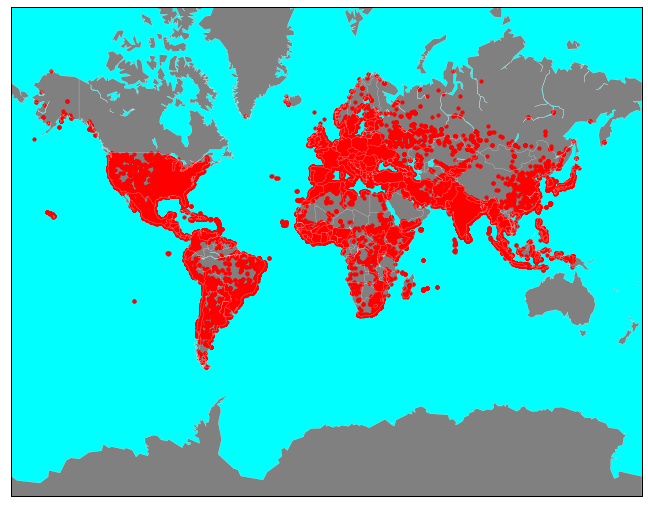

<Figure size 432x288 with 0 Axes>

In [32]:
#Graphed (map) sep2019-sep2020
fig = plt.figure(figsize=(12,9))
lat = acled_event_protests_201909_202009['latitude'].values
lon = acled_event_protests_201909_202009['longitude'].values
protests = acled_event_protests_201909_202009['event_type'].values
#area = acled_event_protests
m = Basemap(projection='merc', \
            llcrnrlat=-80, urcrnrlat=80, \
            llcrnrlon=-180, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)
m.drawcoastlines(color='white', linewidth=0.2)
m.drawcountries(color='white', linewidth=0.2)

m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='grey')
lons = range(50)
lats = range(25, 75)
vals = range(50,100)

x, y = m(lon, lat)
plt.scatter(x, y, 10, marker='o', color='Red') 
#plt.scatter(lons, lats, c=vals, cmap='Reds')
#plt.colorbar()
plt.show()
plt.savefig('../images/Protests_2019_2020.png', bbox_inches = 'tight')

c:\Users\Morgan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


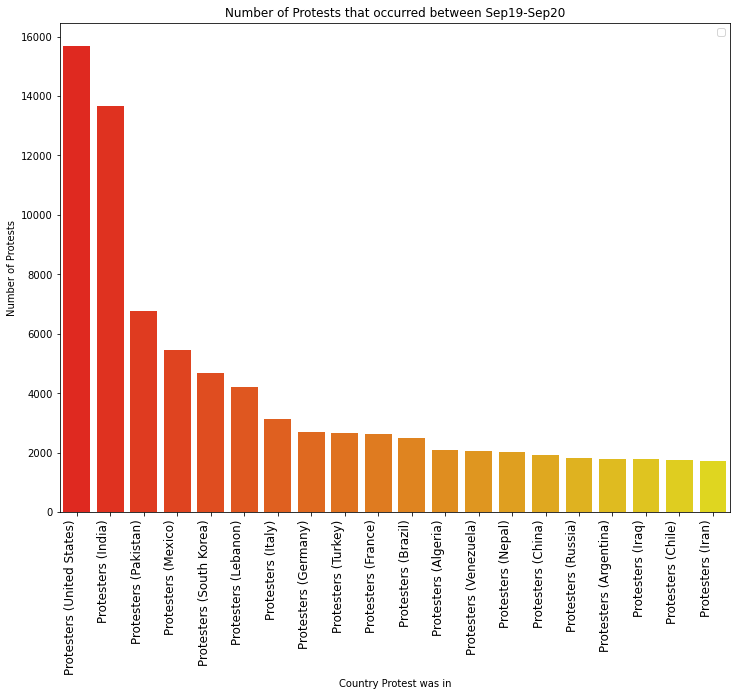

<Figure size 432x288 with 0 Axes>

In [46]:
#Graphed (bar) sep2019-sep2020
fig, ax = plt.subplots(figsize=(12,9))
sns.barplot(acled_df_sort_bar_toptwenty_2019_2020.index,acled_df_sort_bar_toptwenty_2019_2020, palette='autumn')
ax.set_xticklabels(acled_df_sort_bar_toptwenty_2019_2020.index, rotation=90, horizontalalignment = 'right', fontsize = '12')
plt.xlabel("Country Protest was in")
plt.ylabel("Number of Protests")
plt.title("Number of Protests that occurred between Sep19-Sep20")
plt.legend()
plt.show()
plt.savefig('../images/Protests_bar_2019_2020.png', bbox_inches = 'tight')

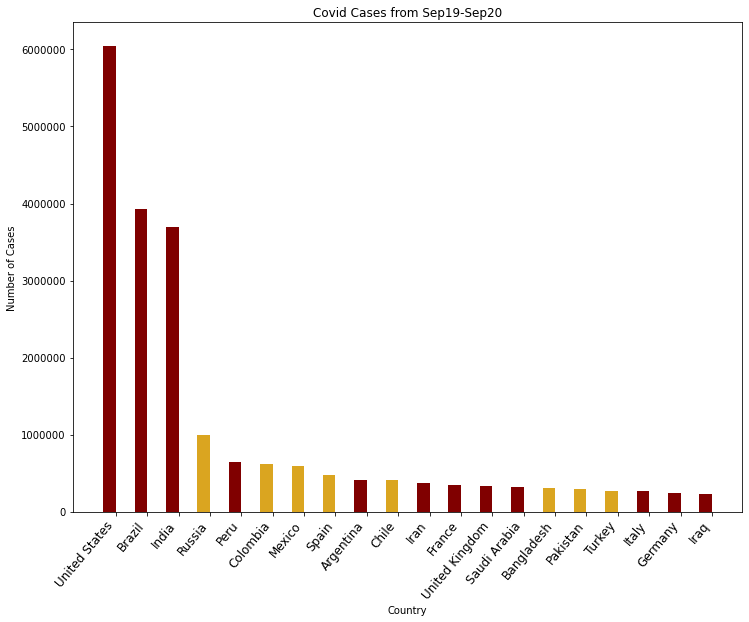

In [59]:
#Graphing Top Channels by views and likes
fig, ax = plt.subplots(figsize=(12,9))
cases = top_country_covid_cases_2019_2020['new_cases']
country = top_country_covid_cases_2019_2020.index
  
country_axis = np.arange(len(country))
  
plt.bar(country_axis  - 0.2, cases, 0.4, label = 'cases', color=['maroon', 'maroon', 'maroon', 'goldenrod', 'maroon', 'goldenrod', 'goldenrod', 'goldenrod', 'maroon', 'goldenrod', 'maroon', 'maroon', 'maroon', 'maroon', 'goldenrod', 'goldenrod', 'goldenrod', 'maroon', 'maroon', 'maroon'])
plt.ticklabel_format(axis='y',style='plain')
#ax.set_xticklabels(cat_name, rotation=60, horizontalalignment='right', fontsize='12')
plt.xticks(country_axis , country, rotation=50, horizontalalignment='right', fontsize='12')
plt.xlabel("Country")
plt.ylabel("Number of Cases")
plt.title("Covid Cases from Sep19-Sep20")

#Styling graph
sns.color_palette()
plt.show()

In [35]:

# #Graphed Peaceful protests (bar) sep2019-sep2020
# fig, ax = plt.subplots(figsize=(12,9))
# ax.bar(acled_df_sort_bar_toptwenty_pp_2019_2020.index,acled_df_sort_bar_toptwenty_pp_2019_2020, stacked=True)
# ax.set_xticklabels(acled_df_sort_bar_toptwenty_pp_2019_2020.index, rotation=90, horizontalalignment = 'right', fontsize = '12')
# plt.show


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


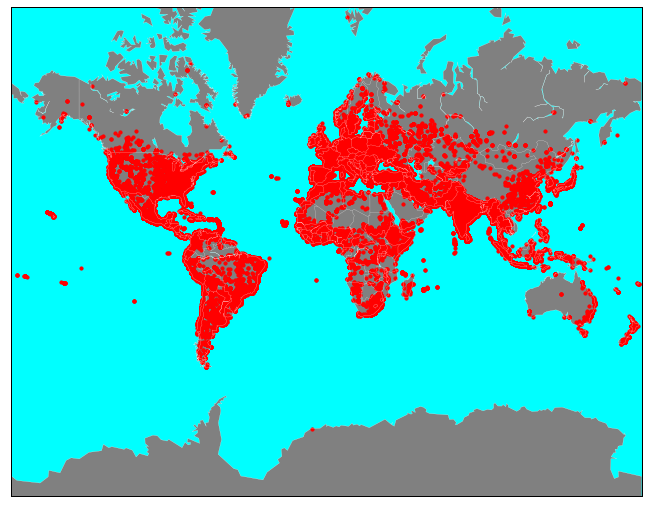

<Figure size 432x288 with 0 Axes>

In [36]:
#Graphed (map) sep2020-sep2021
fig = plt.figure(figsize=(12,9))
lat = acled_event_protests_202009_202109['latitude'].values
lon = acled_event_protests_202009_202109['longitude'].values
protests = acled_event_protests_202009_202109['event_type'].values
#area = acled_event_protests
m = Basemap(projection='merc', \
            llcrnrlat=-80, urcrnrlat=80, \
            llcrnrlon=-180, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)
m.drawcoastlines(color='white', linewidth=0.2)
m.drawcountries(color='white', linewidth=0.2)

m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='grey')
lons = range(50)
lats = range(25, 75)
vals = range(50,100)

x, y = m(lon, lat)
plt.scatter(x, y, 10, marker='o', color='Red') 
#plt.scatter(lons, lats, c=vals, cmap='Reds')
#plt.colorbar()
plt.show()
plt.savefig('../images/Protests_2020_2021.png', bbox_inches = 'tight')

c:\Users\Morgan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


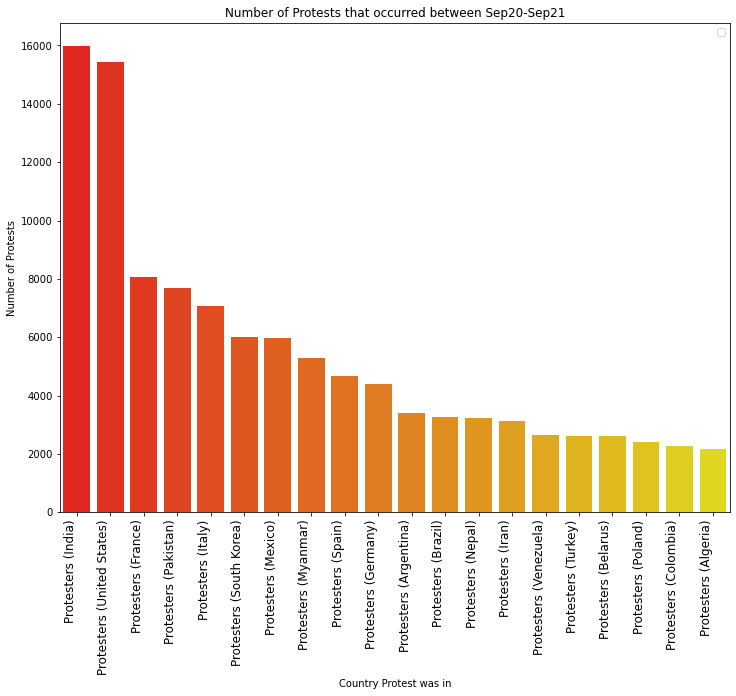

In [60]:
#Graphed (bar) sep2020-sep2021
fig, ax = plt.subplots(figsize=(12,9))
sns.barplot(acled_df_sort_bar_toptwenty_2020_2021.index,acled_df_sort_bar_toptwenty_2020_2021, palette='autumn')
ax.set_xticklabels(acled_df_sort_bar_toptwenty_2020_2021.index, rotation=90, horizontalalignment = 'right', fontsize = '12')
plt.xlabel("Country Protest was in")
plt.ylabel("Number of Protests")
plt.title("Number of Protests that occurred between Sep20-Sep21")
plt.legend()
plt.show
plt.savefig('../images/Protests_bar_2020_2021.png', bbox_inches = 'tight')

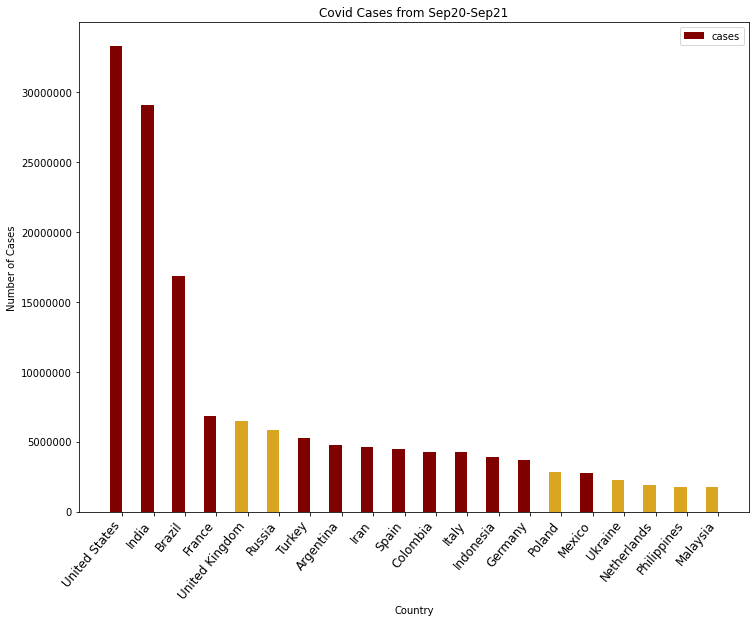

In [61]:

#Graphing Top Channels by views and likes
fig, ax = plt.subplots(figsize=(12,9))
cases = top_country_covid_cases_2020_2021['new_cases']
country = top_country_covid_cases_2020_2021.index
  
country_axis = np.arange(len(country))
  
plt.bar(country_axis  - 0.2, cases, 0.4, label = 'cases', color=['maroon', 'maroon', 'maroon', 'maroon', 'goldenrod', 'goldenrod', 'maroon', 'maroon', 'maroon', 'maroon', 'maroon', 'maroon', 'maroon', 'maroon', 'goldenrod', 'maroon', 'goldenrod', 'goldenrod', 'goldenrod', 'goldenrod'])
plt.ticklabel_format(axis='y',style='plain')
#ax.set_xticklabels(cat_name, rotation=60, horizontalalignment='right', fontsize='12')
plt.xticks(country_axis , country, rotation=50, horizontalalignment='right', fontsize='12')
plt.xlabel("Country")
plt.ylabel("Number of Cases")
plt.title("Covid Cases from Sep20-Sep21")
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


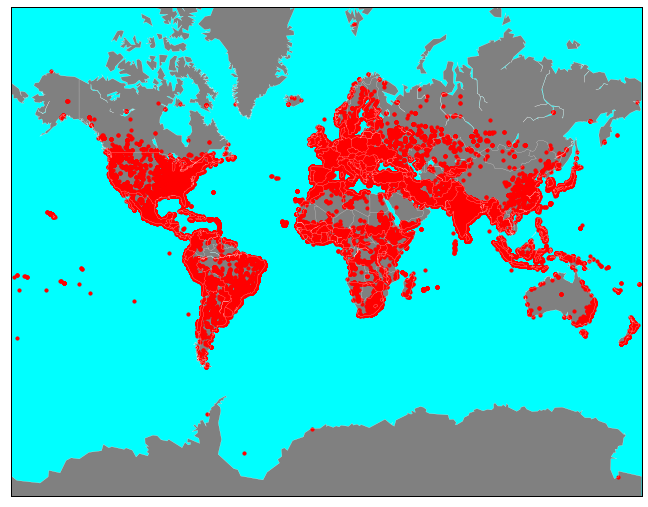

<Figure size 432x288 with 0 Axes>

In [39]:
#Graphed (map) sep2021-sep2022
fig = plt.figure(figsize=(12,9))
lat = acled_event_protests_202109_202209['latitude'].values
lon = acled_event_protests_202109_202209['longitude'].values
protests = acled_event_protests_202109_202209['event_type'].values
#area = acled_event_protests
m = Basemap(projection='merc', \
            llcrnrlat=-80, urcrnrlat=80, \
            llcrnrlon=-180, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)
m.drawcoastlines(color='white', linewidth=0.2)
m.drawcountries(color='white', linewidth=0.2)

m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='grey')
lons = range(50)
lats = range(25, 75)
vals = range(50,100)

x, y = m(lon, lat)
plt.scatter(x, y, 10, marker='o', color='Red') 
#plt.scatter(lons, lats, c=vals, cmap='Reds')
#plt.colorbar()
plt.show()
plt.savefig('../images/Protests_2021_2022.png', bbox_inches = 'tight')


C:\Users\Morgan\AppData\Local\Temp\ipykernel_25008\1298674680.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(acled_df_sort_bar_toptwenty_2021_2022.index, rotation=90, horizontalalignment = 'right', fontsize = '12')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


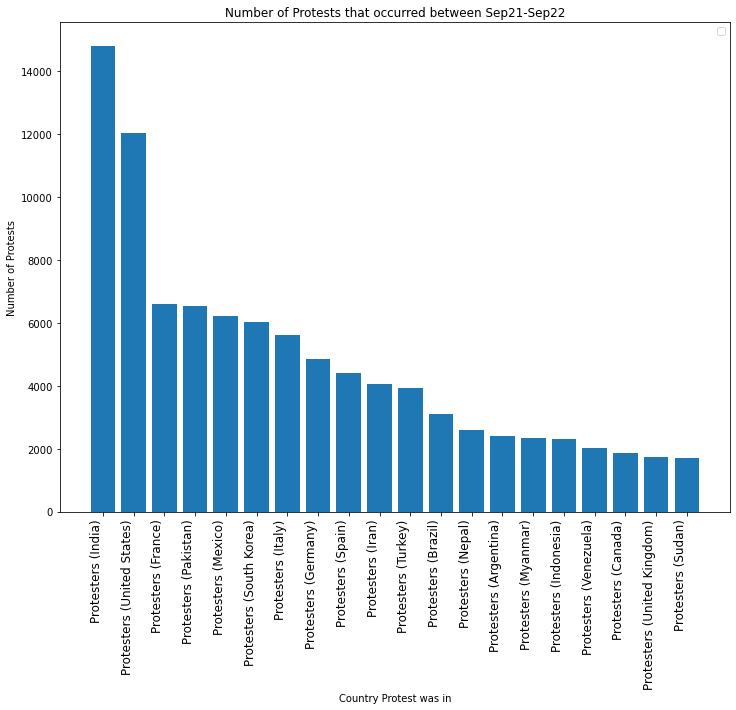

In [40]:
#Graphed (bar) sep2021-sep2022
fig, ax = plt.subplots(figsize=(12,9))
ax.bar(acled_df_sort_bar_toptwenty_2021_2022.index,acled_df_sort_bar_toptwenty_2021_2022)
ax.set_xticklabels(acled_df_sort_bar_toptwenty_2021_2022.index, rotation=90, horizontalalignment = 'right', fontsize = '12')
plt.xlabel("Country Protest was in")
plt.ylabel("Number of Protests")
plt.title("Number of Protests that occurred between Sep21-Sep22")
plt.legend()
plt.show
plt.savefig('../images/Protests_bar_2021_2022.png', bbox_inches = 'tight')

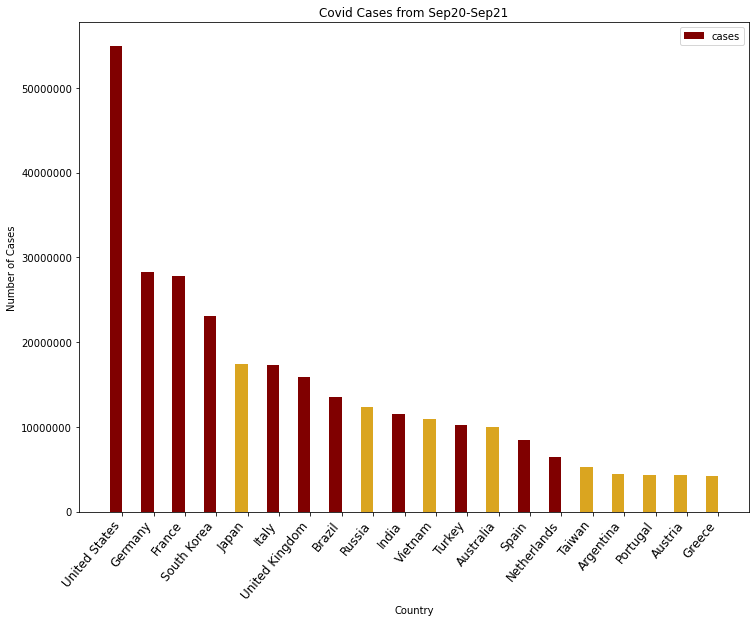

In [73]:
#Graphing Top Channels by views and likes
fig, ax = plt.subplots(figsize=(12,9))
cases = top_country_covid_cases_2021_2022['new_cases']
country = top_country_covid_cases_2021_2022.index
  
country_axis = np.arange(len(country))
  
plt.bar(country_axis  - 0.2, cases, 0.4, label = 'cases', color=['maroon', 'maroon', 'maroon', 'maroon', 'goldenrod', 'maroon', 'maroon', 'maroon', 'goldenrod', 'maroon', 'goldenrod', 'maroon', 'goldenrod', 'maroon', 'maroon', 'goldenrod', 'goldenrod', 'goldenrod', 'goldenrod', 'goldenrod'])
plt.ticklabel_format(axis='y',style='plain')
#ax.set_xticklabels(cat_name, rotation=60, horizontalalignment='right', fontsize='12')
plt.xticks(country_axis , country, rotation=50, horizontalalignment='right', fontsize='12')
plt.xlabel("Country")
plt.ylabel("Number of Cases")
plt.title("Covid Cases from Sep20-Sep21")
plt.legend()
plt.show()
